In [24]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%reload_ext autoreload
%autoreload 2
%aimport feature_preprocessing_pipeline
%aimport build_model_by_brand
%aimport build_model
%aimport build_model_for_merged_data
%aimport prepare_data
%aimport bs_lib.bs_preprocess_lib
%aimport constants

In [23]:
from sklearn import set_config
from os import system
from os.path import join, isfile
from joblib import dump, load
from feature_preprocessing_pipeline import categorize, extract_features, clean_variables
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import make_scorer, mean_squared_error
from build_model_by_brand import evaluate_all_models,evaluate_all_refitted_models, get_set_split,get_best_estimators_params
from build_model import get_one_model_for_all_iterative,evaluate_prediction
import build_model_for_merged_data as bmmd #import evaluate_model,get_best_estimator
from prepare_data import load_prepared_file
from bs_lib.bs_preprocess_lib import plot_validation_curve,get_learning_curve,plot_learning_curve
import constants as cnst
#from dtreeviz.trees import dtreeviz

In [81]:

from IPython.core.display import display, HTML 
from sklearn.utils import estimator_html_repr 
set_config(display='diagram') 

In [4]:
dataset_directory_path = 'dataset/'
model_directory_path = 'model/'

In [57]:
model_name = 'mercedes_optimize_rmse_2427'
model_filename = f'{model_name}.joblib'
model_path = join(cnst.MODEL_DIR_PATH, model_filename)
model = load(model_path)

In [82]:
X_test = pd.read_csv(join(dataset_directory_path, 'X_test.csv'), index_col=0)
y_test = pd.read_csv(join(dataset_directory_path, 'y_test.csv'), index_col=0)

## Description du model 

### Variables

In [78]:
rfr = model[2]
print(f"Le model {rfr} a {rfr.n_features_in_} variables")

Le model RandomForestRegressor(max_depth=50, max_features=None, min_samples_split=6,
                      n_estimators=10, n_jobs=-1, verbose=False) a 57 variables


### Durée d'entraînement

In [64]:
print(f"Test set:\n X {X_test.shape} y {y_test.shape}")


Test set:
 X (7824, 9) y (7824, 1)


<center><img src="./assets/one_model_by_brand_overview.svg"/></center>

### Traitement des fichiers sources
<center><img src="./assets/file_processing.svg"/></center>

### Préparation des données

<center><img src="./assets/prepare_data.svg"/></center>

#### Suppression ou Imputation des *anomalies*

<center><img src="./assets/outliers.svg"/></center>

### Séparation des données

<center><img src="./assets/split_data.svg"/></center>

### Création du Modèle

<center><img src="./assets/build_model.svg"/></center>

#### Extract Features

Création de nouvelles variables:
1. `age`: $max(year)-year$
1. `model_count`: nombre d'occurence du modèle dans le dataset
1. `occurence_relative`: $\frac{count(model)}{count(allmodel)}$
1. `mileage_per_year`: $\frac{mileage}{age}$
1. `mpg_per_year`: $\frac{mpg}{age}$
1. `tax_per_year`: $\frac{tax}{age}$
1. `engine_size_per_year`: $\frac{enginesize}{age}$
1. `esoteric_composite_ratio`

Suivant la marque de voiture et/ou le modèle de prédiction créé, certaines améliorent le score de prédictions.

#### Transform Features
1. `PolynomialFeature` pour les variables numériques.
1. `KBinsDiscretizer` pour les variables `mpg`, `tax`, `engine_size`, `year`.
1. `OneHotEncoder` ou `OrdinalEncoder` pour les variables `model`, `brand`, `transmission`, `fuel_type`. 

Pour l'`OrdinalEncoder`, les catégories ont été triées relativement à la variable dépendante `price` par **ordre ascendant**.


### Pipeline

<center><img src="./assets/pipeline.svg"/></center>

### Valeurs des paramètres du pipeline

<center><img src="./assets/best_params_search.svg"/></center>

## Recherche de Modèles

1. Un modèle par marque
1. Un modèle pour toutes les marques
1. Un modèle incrémental pour toutes les marques

### Couches d'optimisation du modèle

<center><img src="./assets/optimization.svg"/></center>

### Par marques

Création d'un modèle par marques

#### Évaluation du modèle de base

In [135]:
evaluate_all_models(search_term='model',exclude=['base_score','all_brand'])

PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                                  
┏━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃  Brand   ┃ RMSE ┃ Target mean ┃ Prediction mean ┃   Model path   ┃
┡━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│   Audi   │ 2866 │    23179    │      23099      │   audi_model   │
│   Bmw    │ 2534 │    22672    │      22507      │   bmw_model    │
│   Ford   │ 1402 │    12334    │      12326      │   ford_model   │
│ Hyundai  │ 1585 │    12785    │      12888      │ hyundai_model  │
│ Mercedes │ 3469 │    24313    │      24126      │ mercedes_model │
│   Opel   │ 1146 │    10303    │      10228      │   opel_model   │
│  Skoda   │ 2743 │    14248    │      14099      │  skoda_model   │
│  Toyota  │ 1504 │    12185    │      12134      │  toyota_model  │
│    Vw    │ 2026 │    16832    │      16723      │    vw_model    │
└──────────┴──────┴─────────────┴─────────────────┴────────────────┘

#### Optimisation des transformations

In [132]:
evaluate_all_models(search_term='rmse')

PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                                               
┏━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Brand   ┃ RMSE ┃ Target mean ┃ Prediction mean ┃         Model path          ┃
┡━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   Audi   │ 1842 │    23179    │      23047      │   audi_optimize_rmse_1842   │
│   Bmw    │ 1635 │    22672    │      22553      │   bmw_optimize_rmse_1635    │
│   Ford   │ 801  │    12334    │      12276      │   ford_optimize_rmse_801    │
│ Hyundai  │ 733  │    12785    │      12731      │  hyundai_optimize_rmse_733  │
│ Mercedes │ 2427 │    24313    │      24156      │ mercedes_optimize_rmse_2427 │
│   Opel   │ 679  │    10303    │      10255      │   opel_optimize_rmse_679    │
│  Skoda   │ 1428 │    14248    │      14163      │  skoda_optimize_rmse_1428   │
│  Toyota  │ 919  │    12185    │      12106      │  toyota_optimize_rmse_919   │
│    Vw    │ 1162 │    16832    │      16777      │    vw_optimize_rmse_1162    │
└──────────┴──────┴─────────────┴─────────────────┴─────────────────────────────┘

#### Optimisation de l'estimateur

In [131]:
# Modèle avec pipeline et estimateur optimisé
#get_best_estimators_params(search_term='optimize_rmse', exclude_term=['estimator'], verbose=True)
evaluate_all_models(search_term='optimized_rmse',exclude=[])

PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                                                          
┏━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Brand   ┃ RMSE ┃ Target mean ┃ Prediction mean ┃               Model path               ┃
┡━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   Audi   │ 1567 │    23179    │      23071      │   audi_estimator_optimized_rmse_1567   │
│   Bmw    │ 1635 │    22672    │      22553      │   bmw_estimator_optimized_rmse_1635    │
│   Ford   │ 801  │    12334    │      12276      │   ford_estimator_optimized_rmse_801    │
│ Hyundai  │ 733  │    12785    │      12731      │  hyundai_estimator_optimized_rmse_733  │
│ Mercedes │ 2073 │    24313    │      24143      │ mercedes_estimator_optimized_rmse_2073 │
│   Opel   │ 586  │    10303    │      10249      │   opel_estimator_optimized_rmse_586    │
│  Skoda   │ 1825 │    14248    │      14197      │  skoda_estimator_optimized_rmse_1825   │
│  Toyota  │ 845  │    12185    │      12114      │  toyota_estimator_optimized_rmse_845   │
│    Vw    │ 947  │    16832    │      16752      │    vw_estimator_optimized_rmse_947     │
└──────────┴──────┴─────────────┴─────────────────┴────────────────────────────────────────┘

#### Refit?

In [116]:
# load performance
evaluate_all_refitted_models(base_model_search_term='model', 
                             params_search_term='rmse',
                             model_exclude=['base_score_model.joblib','all_brand'],
                             params_exclude=[])
# Refit toyota_model.joblib using toyota.csv with parameters from toyota_optimize_rmse_919.json

PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                              
┏━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃  Brand   ┃ RMSE ┃ Target mean ┃ Prediction mean ┃ Model path ┃
┡━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  Toyota  │ 1205 │    12185    │      12125      │     -      │
│ Mercedes │ 3325 │    24313    │      24136      │     -      │
│   Audi   │ 2601 │    23179    │      23058      │     -      │
│   Bmw    │ 2467 │    22672    │      22499      │     -      │
│   Ford   │ 1264 │    12334    │      12338      │     -      │
│    Vw    │ 1986 │    16832    │      16694      │     -      │
│   Opel   │ 1103 │    10303    │      10221      │     -      │
│ Hyundai  │ 1496 │    12785    │      12915      │     -      │
│  Skoda   │ 2663 │    14248    │      14103      │     -      │
└──────────┴──────┴─────────────┴─────────────────┴────────────┘

#### Essais de prédictions

In [106]:
brand = 'opel'
model_name = 'opel_optimize_rmse_679'
model_filename = f'{model_name}.joblib'
model_path = join(model_directory_path, model_filename)
model = load(model_path)
filename = f"{brand}.csv"
df = load_prepared_file(filename=filename)
X_train, X_val, X_test, y_train, y_val, y_test = get_set_split(df, target='price')
evaluate_prediction(model, X_test, y_test,sample=10,add_columns=['model','transmission','fuel_type'])

RMSE: 935.6136668953593


MODEL PREDICTION TESTING ────────────────────────────────────────────────────────────────────

Prediction results                                                                   
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Prediction ┃ Real Price ┃ Error ┃ Percentage ┃  model  ┃ transmission ┃ fuel_type ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│   11208    │   10000    │ 1208  │    12 %    │  Astra  │  Semi-Auto   │  Petrol   │
│   15045    │   13481    │ 1564  │    12 %    │  Astra  │    Manual    │  Petrol   │
│    8633    │    8298    │  335  │    4 %     │  Mokka  │    Manual    │  Petrol   │
│    9443    │    8290    │ 1153  │    14 %    │  Astra  │    Manual    │  Petrol   │
│    7752    │    7994    │  242  │    3 %     │  Corsa  │    Manual    │  Petrol   │
│   12641    │   12049    │  592  │    5 %     │ Mokka X │  Semi-Auto   │  Petrol   │
│   10900    │    9959    │  941  │    9 %     │  Astra  │  Automatic   │  Diesel   │
│    9029    │    9135    │  106  │    1 %     │  Corsa  │    Manual    │  Petrol   │
│   12228    │   12999    │  771  │    6 %     │  Mokka  │    Manual    │  Petrol   │
│   11425    │   10195    │ 1230  │    12 %    │ Mokka X │    Manual    │  Petrol   │
└────────────┴────────────┴───────┴────────────┴─────────┴──────────────┴───────────┘

#### Courbe d'apprentissage

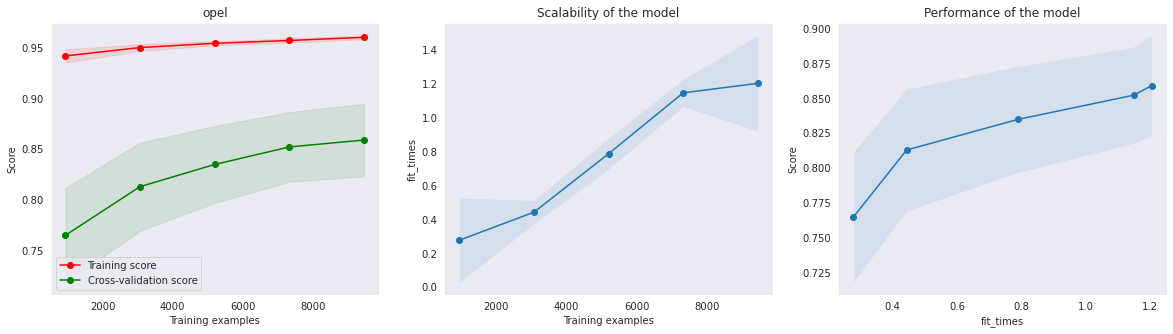

In [117]:
#model.get_params().keys()
mse = make_scorer(mean_squared_error, greater_is_better=False)
#get_learning_curve(model, X_val, y_val, mse, show=True, savefig=False)
plot_learning_curve(model, brand, X_train, y_train, axes=None, ylim=None, cv=20,
                        n_jobs=2, train_sizes=np.linspace(.1, 1.0, 5), show=True,savefig=False)

Le premier graphique montre les courbes d'apprentissage pour l'entraînement et la validation.

Le deuxième graphique montre le nombre d'entraînement du modèle relativement à la taille des données d'entraînement. 

Le troisième graphique montre les scores obtenus relativement au temps d'entraînement du modèle.

### Toutes marques

1. fusion des données en une seule source de données

In [10]:
bmmd.evaluate_model(model_filename='all_brands.joblib', data_filename='all_brands.csv',verbose=False)

Loading all_brands.joblib


PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                                          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Brand         ┃ RMSE ┃ Target mean ┃ Prediction mean ┃ Model path ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Merged Brand Dataset │ 2442 │    16791    │      16697      │     -      │
└──────────────────────┴──────┴─────────────┴─────────────────┴────────────┘

In [14]:
bmmd.get_best_estimator(model_filename='all_brands.joblib', data_filename='all_brands.csv',verbose=False)

Loading all_brands.joblib
Model all_brands_estimator_optimized_rmse_2096 saved @ ./model/all_brands_estimator_optimized_rmse_2096.joblib


In [15]:
bmmd.evaluate_model(model_filename='all_brands_estimator_optimized_rmse_2096.joblib',data_filename='all_brands.csv',verbose=False)

Loading all_brands_estimator_optimized_rmse_2096.joblib


PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                                          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Brand         ┃ RMSE ┃ Target mean ┃ Prediction mean ┃ Model path ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Merged Brand Dataset │ 2096 │    16791    │      16636      │     -      │
└──────────────────────┴──────┴─────────────┴─────────────────┴────────────┘

In [22]:
model = bmmd.get_model(model_filename='all_brands.joblib', data_filename='all_brands.csv',verbose=False)
df = bmmd.get_data('all_brands.csv')
X_train, X_val, X_test, y_train, y_val, y_test = bmmd.get_split_sets(df)
evaluate_prediction(model, X_test, y_test,sample=10,add_columns=['brand','model','transmission','fuel_type'])

Loading all_brands.joblib
RMSE: 3398.3865980622854


MODEL PREDICTION TESTING ────────────────────────────────────────────────────────────────────

Prediction results                                                                           
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Prediction ┃ Real Price ┃ Error ┃ Percentage ┃ brand  ┃  model  ┃ transmission ┃ fuel_ty… ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│   17969    │   17991    │  22   │    0 %     │ toyota │  C-HR   │  Automatic   │  Petrol  │
│   13883    │   11995    │ 1888  │    16 %    │ toyota │  Yaris  │  Automatic   │  Hybrid  │
│   26001    │   25190    │  811  │    3 %     │ skoda  │  Karoq  │  Automatic   │  Diesel  │
│   10959    │   14398    │ 3439  │    24 %    │  opel  │ Mokka X │  Semi-Auto   │  Petrol  │
│   33102    │   26825    │ 6277  │    23 %    │  bmw   │ 3 Seri… │  Automatic   │  Petrol  │
│   11265    │   18490    │ 7225  │    39 %    │  audi  │   Q2    │  Semi-Auto   │  Petrol  │
│   10313    │   10494    │  181  │    2 %     │ toyota │  Yaris  │    Manual    │  Petrol  │
│   10979    │    9898    │ 1081  │    11 %    │   vw   │ Golf SV │    Manual    │  Diesel  │
│   34515    │   36984    │ 2469  │    7 %     │  audi  │   Q5    │  Automatic   │  Diesel  │
│   28188    │   28919    │  731  │    3 %     │  bmw   │ 5 Seri… │  Semi-Auto   │  Diesel  │
└────────────┴────────────┴───────┴────────────┴────────┴─────────┴──────────────┴──────────┘

### Entraînement Incrémental

Le model est entrainé sur chaque jeu de données en conservant les arbres précédemment créés.

In [30]:
get_one_model_for_all(model_to_dump=True, evaluation=True, verbose=False)

PERFORMANCE COMPARISON ──────────────────────────────────────────────────────────────────────

One model by Brand                                                                         
┏━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Brand    ┃ RMSE ┃ Target mean ┃ Prediction mean ┃             Model path              ┃
┡━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inc. Model │ 8652 │    16802    │      11661      │ model/all_brand_model_8652.0.joblib │
└────────────┴──────┴─────────────┴─────────────────┴─────────────────────────────────────┘